In [1]:
!pip install sentence_transformers
!pip install hazm

In [2]:
%cd sample_data

/content/sample_data


In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('TwitterDataset.csv')
print(np.shape(dataset))


(3080, 2)


In [4]:
tweets = dataset.loc[:,"tweets"]
labels = dataset.loc[:,"labels"]

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel
from hazm import *


# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
parsbert_embedding_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
labse_embedding_model = SentenceTransformer('sentence-transformers/LaBSE')
normalizer = Normalizer()

def generate_bert_embedding(tweet):
    tweet = normalizer.normalize(tweet)
    # Tokenize the tweet
    tokens = tokenizer.tokenize(tweet)
    input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokens)])

    # Generate the embedding
    with torch.no_grad():
        outputs = parsbert_embedding_model(input_ids)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

    return embedding.tolist()

def generate_labse_embedding(tweet):

    embeddings = labse_embedding_model.encode(tweet)
    return embeddings.tolist()


In [7]:
from tqdm import tqdm
import time
tweets_embedding = []
for tweet_idx, tweet in enumerate(tqdm(tweets)):
    time.sleep(0.001)
    labse_output = generate_labse_embedding(tweet)
    bert_output = generate_bert_embedding(tweet)
    tweets_embedding.append(bert_output + labse_output)

100%|██████████| 3080/3080 [16:29<00:00,  3.11it/s]


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [9]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 1000)
        self.activation1 = nn.LeakyReLU(0.1)
        self.linear2 = nn.Linear(1000, 512)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(512, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.activation3 = nn.LeakyReLU(0.1)
        self.linear4 = nn.Linear(64, 16)
        self.activation4 = nn.ReLU()
        self.linear5 = nn.Linear(16, output_dim)

    def forward(self, input):
        x = self.linear1(input)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.activation3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        x = self.linear5(x)
        return x

In [10]:
labels = dataset.loc[:,"labels"]

sentences_embedding_tmp = torch.tensor(tweets_embedding)
labels_tmp = torch.tensor(labels.values)

train_emb, val_emb, train_labels, val_labels = train_test_split(sentences_embedding_tmp, labels_tmp, test_size=0.1)

train_data = TensorDataset(train_emb, train_labels)
valid_data = TensorDataset(val_emb, val_labels)

batch_size = 16

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

input_dim = sentences_embedding_tmp.shape[1]
output_dim = 5

model = NeuralNetClassifier(input_dim, output_dim)


criterion = nn.CrossEntropyLoss(torch.tensor([1.0, 1.0, 2.0, 3.0, 2.5] ,dtype=torch.float))

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

In [11]:
from tqdm import tqdm
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
min_valid_loss = np.inf
all_train_losses = []
all_train_accuracies = []

for epoch in range(epochs):
    running_loss = 0.
    avg_loss = 0
    running_acc = 0
    train_len = 0

    model.train()
    for i, (inputs, labels) in tqdm(enumerate(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (labels == output.argmax(-1)).sum().item()
        train_len += len(labels)

        avg_loss = running_loss / len(train_loader)
        if i % 100 == 99:
            avg_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, avg_loss))
            running_loss = 0.
    acc = running_acc/train_len
    all_train_losses.append(avg_loss)
    all_train_accuracies.append(acc)

    print('loss: {} accuracy: {}'.format( avg_loss, acc))

    model.eval()
    predictions = []
    truths = []
    with torch.no_grad():
        for data, labels in valid_loader:
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()

          target = model(data)
          loss = criterion(target,labels)
          valid_loss = loss.item() * data.size(0)

        print(f' Validation Loss: {valid_loss / len(valid_loader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')


    print(f'Epoch {epoch+1}/{epochs}:')
    # print(f'Validation Loss is: {running_loss / len(valid_loader)}')

107it [00:02, 47.93it/s]

  batch 100 loss: 1.6025766932964325


174it [00:04, 42.20it/s]


loss: 0.6735213844255469 accuracy: 0.17496392496392496
 Validation Loss: 0.30420143604278566
Validation Loss Decreased(inf--->6.084029) 	 Saving The Model
Epoch 1/20:


105it [00:02, 35.76it/s]

  batch 100 loss: 1.5124514412879944


174it [00:04, 38.13it/s]


loss: 0.6256844970001572 accuracy: 0.33405483405483405
 Validation Loss: 0.290415096282959
Validation Loss Decreased(6.084029--->5.808302) 	 Saving The Model
Epoch 2/20:


108it [00:02, 46.67it/s]

  batch 100 loss: 1.4199903213977814


174it [00:03, 47.50it/s]


loss: 0.5854330939808111 accuracy: 0.4274891774891775
 Validation Loss: 0.2509199857711792
Validation Loss Decreased(5.808302--->5.018400) 	 Saving The Model
Epoch 3/20:


106it [00:02, 47.77it/s]

  batch 100 loss: 1.315504750609398


174it [00:03, 47.24it/s]


loss: 0.5561188356629734 accuracy: 0.4678932178932179
 Validation Loss: 0.22661116123199462
Validation Loss Decreased(5.018400--->4.532223) 	 Saving The Model
Epoch 4/20:


104it [00:02, 42.06it/s]

  batch 100 loss: 1.227764241695404


174it [00:03, 43.78it/s]


loss: 0.5348446060871256 accuracy: 0.5068542568542569
 Validation Loss: 0.32967686653137207
Epoch 5/20:


104it [00:02, 38.33it/s]

  batch 100 loss: 1.1517924970388413


174it [00:04, 39.42it/s]


loss: 0.501733156113789 accuracy: 0.5165945165945166
 Validation Loss: 0.5494898796081543
Epoch 6/20:


107it [00:02, 48.87it/s]

  batch 100 loss: 1.1549348884820938


174it [00:03, 47.92it/s]


loss: 0.4786541646924512 accuracy: 0.5404040404040404
 Validation Loss: 0.27281501293182375
Epoch 7/20:


106it [00:02, 46.78it/s]

  batch 100 loss: 1.0456646800041198


174it [00:03, 47.64it/s]


loss: 0.4541901737108998 accuracy: 0.5667388167388168
 Validation Loss: 0.3225170373916626
Epoch 8/20:


105it [00:02, 40.54it/s]

  batch 100 loss: 0.9831842303276062


174it [00:04, 41.49it/s]


loss: 0.430711991485508 accuracy: 0.5963203463203464
 Validation Loss: 0.2538342237472534
Epoch 9/20:


104it [00:02, 35.81it/s]

  batch 100 loss: 0.9517969733476639


174it [00:04, 38.76it/s]


loss: 0.4017080786241882 accuracy: 0.6136363636363636
 Validation Loss: 0.7229762554168702
Epoch 10/20:


105it [00:02, 46.60it/s]

  batch 100 loss: 0.8932781594991684


174it [00:03, 46.77it/s]


loss: 0.37791016903416863 accuracy: 0.6388888888888888
 Validation Loss: 0.167830228805542
Validation Loss Decreased(4.532223--->3.356605) 	 Saving The Model
Epoch 11/20:


106it [00:02, 44.61it/s]

  batch 100 loss: 0.8211667108535766


174it [00:03, 45.39it/s]


loss: 0.3514074080291836 accuracy: 0.6601731601731602
 Validation Loss: 0.18847899436950682
Epoch 12/20:


104it [00:02, 36.44it/s]

  batch 100 loss: 0.750185851752758


174it [00:04, 38.36it/s]


loss: 0.3466505127391596 accuracy: 0.6847041847041847
 Validation Loss: 0.2750098466873169
Epoch 13/20:


108it [00:02, 46.55it/s]

  batch 100 loss: 0.6891779863834381


174it [00:04, 42.03it/s]


loss: 0.2967875998938221 accuracy: 0.7229437229437229
 Validation Loss: 0.5501441955566406
Epoch 14/20:


105it [00:02, 46.08it/s]

  batch 100 loss: 0.6349296259880066


174it [00:03, 45.91it/s]


loss: 0.28726403458022526 accuracy: 0.7334054834054834
 Validation Loss: 0.5484832763671875
Epoch 15/20:


105it [00:02, 45.38it/s]

  batch 100 loss: 0.5587521299719811


174it [00:03, 45.56it/s]


loss: 0.24827833644960118 accuracy: 0.7680375180375181
 Validation Loss: 0.38351192474365237
Epoch 16/20:


104it [00:02, 36.52it/s]

  batch 100 loss: 0.5025889508426189


174it [00:04, 36.73it/s]


loss: 0.21782791289104814 accuracy: 0.7929292929292929
 Validation Loss: 0.3282195806503296
Epoch 17/20:


107it [00:02, 45.82it/s]

  batch 100 loss: 0.4680161543190479


174it [00:03, 43.87it/s]


loss: 0.1909213955888803 accuracy: 0.8192640692640693
 Validation Loss: 0.3135713815689087
Epoch 18/20:


105it [00:02, 45.44it/s]

  batch 100 loss: 0.39134016409516337


174it [00:03, 45.19it/s]


loss: 0.16221224208330287 accuracy: 0.8502886002886003
 Validation Loss: 0.2621518611907959
Epoch 19/20:


105it [00:02, 46.29it/s]

  batch 100 loss: 0.34900306560099126


174it [00:04, 43.31it/s]


loss: 0.14231647435447264 accuracy: 0.8701298701298701
 Validation Loss: 0.4633148670196533
Epoch 20/20:


In [12]:
feelings = ["Happy/Agreement", "Sad/Disagreement", "Angry", "Neutral", "Emotional"]

best_model = NeuralNetClassifier(input_dim, output_dim)
best_model.load_state_dict(torch.load('saved_model.pth'))


file = open('angry_words.txt', 'r')
angry_lines = file.readlines()
file.close()

file = open('passionate_words.txt', 'r')
emotional_lines = file.readlines()
file.close()

file = open('sad_words.txt', 'r')
sad_lines = file.readlines()
file.close()

file = open('happy_words.txt', 'r')
happy_lines = file.readlines()
file.close()
list_of_happy_emojis = ['🤣', '😂', '✨', '😄']
list_of_sad_emojis = ['😭', '😔', '😥']

def predict_sentence_feeling(test_tweet):

    labse_output = generate_labse_embedding(test_tweet)
    bert_output = generate_bert_embedding(test_tweet)
    tmp_embedding = bert_output + labse_output

    sentence_tensor = torch.tensor(tmp_embedding)
    sentence_tensor = sentence_tensor.unsqueeze(0)
    sentence_tensor = sentence_tensor.to(device)

    for emoji in list_of_happy_emojis:
      if emoji in test_tweet:
        return 0

    for emoji in list_of_sad_emojis:
      if emoji in test_tweet:
        return 1

    best_model.eval()
    with torch.no_grad():
        output = best_model(sentence_tensor)

    probabilities = F.softmax(output, dim=1)
    cons_score, predicted_label = torch.max(probabilities, dim=1)
    predicted_label = predicted_label.item()
    if cons_score.item() >= 0.8:
      return predicted_label
    else:
      words_of_sentence = test_tweet.split(" ")
      for word in words_of_sentence:
        word_with_enter = word + '\n'
        for keyword in angry_lines:
          if keyword in word or keyword == word_with_enter:
            return 2

      for word in words_of_sentence:
        word_with_enter = word + '\n'
        for keyword in sad_lines:
          if keyword in word or keyword == word_with_enter:
            return 1

      for word in words_of_sentence:
        word_with_enter = word + '\n'
        for keyword in emotional_lines:
          if keyword in word or keyword == word_with_enter:
            return 4


      for word in words_of_sentence:
        word_with_enter = word + '\n'
        for keyword in happy_lines:
          if keyword in word or keyword == word_with_enter:
            return 0


      return predicted_label

In [13]:
tweet_topic_list = [0, 0, 0, 0, 0 ,0, 0, 0]
tweet_sentiments = [0, 0, 0, 0, 0]

In [15]:
test_set = pd.read_csv('TestSet.csv')
test_tweets = test_set.loc[:,"tweets"].values
test_labels = test_set.loc[:,"labels"].values

from sklearn.metrics import accuracy_score, precision_score
from transformers import pipeline


pred_list = []
for idx, tweet in enumerate(test_tweets):
  tweet = normalizer.normalize(tweet)
  current_pred = predict_sentence_feeling(tweet)
  pred_list.append(current_pred)
  tweet_sentiments[current_pred] += 1
  pipe = pipeline("text-classification", model="HooshvareLab/bert-fa-base-uncased-clf-persiannews")
  label = pipe(tweet)[0]['label']

  if label == 'اقتصادی':
    tweet_topic_list[0] += 1
  elif label == 'بین الملل':
    tweet_topic_list[1] += 1
  elif label == 'سیاسی':
    tweet_topic_list[2] += 1
  elif label == 'علمی فناوری':
    tweet_topic_list[3] += 1
  elif label == 'فرهنگی هنری':
    tweet_topic_list[4] += 1
  elif label == 'ورزشی':
    tweet_topic_list[5] += 1
  elif label == 'پزشکی':
    tweet_topic_list[6] += 1
  elif label == 'اجتماعی':
    tweet_topic_list[7] += 1

print("The accuracy is: " + str(accuracy_score(test_labels, pred_list)))

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


The accuracy is: 0.7408637873754153


In [16]:
print(tweet_topic_list)

[14, 2, 16, 35, 77, 59, 24, 74]


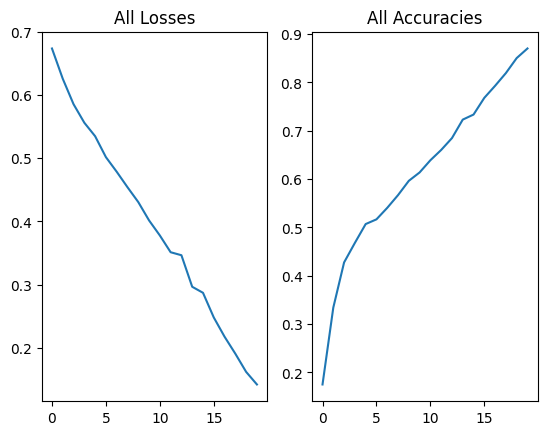

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)

ax[0].plot(all_train_losses)
ax[0].set_title("All Losses")

ax[1].plot(all_train_accuracies)
ax[1].set_title("All Accuracies")

plt.show()


<Axes: >

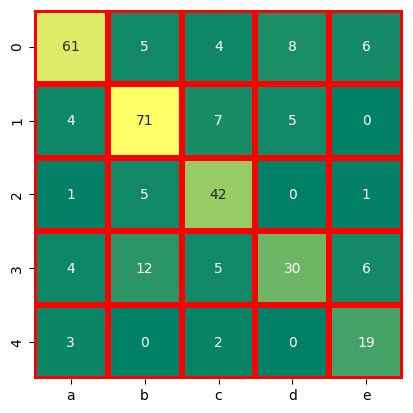

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, pred_list)
sns.heatmap(conf_matrix, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=['a','b','c','d','e'])


In [20]:
export_list_tweet_sentiments = []
for num in tweet_sentiments:
  export_list_tweet_sentiments.append(str(num))


export_list_tweet_topics = []
for num in tweet_topic_list:
  export_list_tweet_topics.append(str(num))

final_tweet_sentiment_string = '#'.join(export_list_tweet_sentiments)
final_tweet_topic_string = '#'.join(export_list_tweet_topics)